CLASSIFICATION USING BBOX

In [31]:
import os
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical
from sklearn.utils import class_weight
from sklearn.metrics import classification_report
print(tf.__version__)
print(tf.config.list_physical_devices('GPU'))
import matplotlib.pyplot as plt
import pandas as pd
import cv2 
import itertools
import numpy as np
from sklearn.model_selection import train_test_split
import random

try:
    tf.config.experimental.enable_op_determinism()
    print("Op Determinism Abilitato!")
except AttributeError:
    print("Attenzione: La tua versione di TF è troppo vecchia per enable_op_determinism.")

def reset_seeds(seed=42):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
SEEDS = [7,42,123,555,999]

2.21.0-dev20251210
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Op Determinism Abilitato!


DATASET LOADING

In [32]:
def load_dataset():
    folder='dataset/images'
    data=[]
    for filename in sorted(os.listdir(folder)):   
        img_path=os.path.join(folder,filename)
        img=cv2.imread(img_path) #opencv save in bgr
        data.append({
            'image':img,
            'filename':filename
        })
    data_map = {item['filename']: item['image'] for item in data}
    print('file name is: ',data[0]['filename'], 'shape of the image is:  ', data[0]['image'].shape )
    label_map={'goalpost':0,
               'ball':1,
               'robot':2,
               'goalspot':3,
               'centerspot':4}
    label=pd.read_csv('dataset/raw/bbx_annotations.csv')
    print(label.shape, label.iloc[0]['filename'])
    #images order is random, and for 1 image you can have more class

    print('we have', len(label['class'].unique()), 'different classes')

    final_cropped_data=[]
    for i,lab in label.iterrows():
        if lab['filename'] in sorted(os.listdir(folder)):
            img=data_map[lab['filename']]
            cropped_img=img[lab['ymin']:lab['ymax'],lab['xmin']:lab['xmax']]
            final_cropped_data.append({
                'image':cropped_img,
                'filename':lab['filename'],
                'class': label_map[lab['class']] 
            })
    return final_cropped_data

DATA MODELLING

In [33]:
def dataset_modelling(dataset):
    IMG_SIZE = (128, 128)

    dataset_df = pd.DataFrame(dataset)
    dataset_df['image'] = dataset_df['image'].apply(lambda x: cv2.resize(x, IMG_SIZE))
    final_dataset=dataset_df.drop(columns=['filename'])
    final_dataset = final_dataset.sample(frac=1, random_state=42).reset_index(drop=True)
    df_train, df_test = train_test_split(final_dataset, test_size=0.2, random_state=42)
    x_train = np.array(df_train['image'].tolist()).astype('float32') /255.0
    y_train = np.array(df_train['class'].tolist()).astype('float32')
    
    x_test = np.array(df_test['image'].tolist()).astype('float32') / 255.0
    y_test = np.array(df_test['class'].tolist()).astype('float32') 
    return x_train, y_train,x_test,y_test


CLASS WEIGHT

In [34]:
def compute_weight(y_train):
    if len(y_train.shape) > 1 and y_train.shape[1] > 1:
        y_integers = np.argmax(y_train, axis=1)
    else:
        y_integers = y_train

    class_weights = class_weight.compute_class_weight(
        class_weight='balanced',
        classes=np.unique(y_integers),
        y=y_integers
    )
    class_weights_dict = dict(enumerate(class_weights))
    return class_weights_dict

MODEL BUILDING

In [35]:
def build_model():
    model=models.Sequential()
    model.add(tf.keras.Input(shape=(128,128,3)))

    for i in range(4):
        kernel_number=16*(2**i)
        model.add(layers.Conv2D(kernel_number,(7,7),activation='relu',padding='same'))
        model.add(layers.AveragePooling2D((3,3),strides=2,padding='same'))
    
    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.Dense(128,activation='relu'))
    model.add(layers.Dense(128,activation='relu'))
    model.add(layers.Dense(5,activation='softmax'))

    #model.summary()
    return model

MAIN

file name is:  lower_100056_jpg.rf.ec9852c66b4eee4a185317210a378f16.jpg shape of the image is:   (240, 320, 3)
(8125, 8) upper_604302_jpg.rf.6215ee30a829ec658154eb4d067dfdf5.jpg
we have 5 different classes


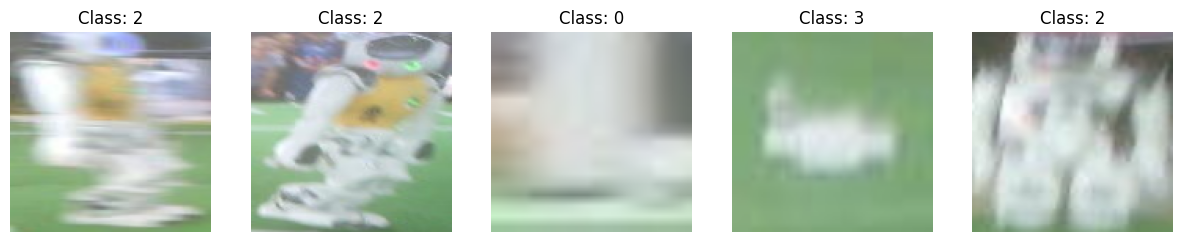


 ================== INIZIO CICLO CON SEED: 7 ================== 
Epoch 1/120


E0000 00:00:1765633632.168047 3779839 node_def_util.cc:682] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


219/219 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 1.2561 - precision: 0.5931 - recall: 0.3772 - val_loss: 1.2042 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/120
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 1.2049 - precision: 0.6022 - recall: 0.4919 - val_loss: 1.1256 - val_precision: 0.6934 - val_recall: 0.6331
Epoch 3/120
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 1.1903 - precision: 0.6016 - recall: 0.5648 - val_loss: 1.1390 - val_precision: 0.7549 - val_recall: 0.5771
Epoch 4/120
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 1.1882 - precision: 0.6016 - recall: 0.5782 - val_loss: 0.9940 - val_precision: 0.7555 - val_recall: 0.5931
Epoch 5/120
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.9601 - precision: 0.7402 - recall: 0.5265 - val_loss: 0.7860 - val_precision: 0.8142 - val_recall: 0.5509
Epoch 6/120
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.8380 - precision: 0.7597 - recall: 0.5379 - val_loss: 0.6908 - val_precision: 0.8074 - val

E0000 00:00:1765633709.978199 3779839 node_def_util.cc:682] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}



 ================== INIZIO CICLO CON SEED: 42 ================== 
Epoch 1/120
219/219 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 1.2448 - precision: 0.6041 - recall: 0.4149 - val_loss: 1.3540 - val_precision: 0.6343 - val_recall: 0.6343
Epoch 2/120
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 1.2062 - precision: 0.6404 - recall: 0.4161 - val_loss: 1.1528 - val_precision: 0.7528 - val_recall: 0.2297
Epoch 3/120
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 1.0859 - precision: 0.6794 - recall: 0.5073 - val_loss: 1.3073 - val_precision: 0.6419 - val_recall: 0.6331
Epoch 4/120
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.9256 - precision: 0.7756 - recall: 0.5061 - val_loss: 0.6768 - val_precision: 0.8456 - val_recall: 0.5760
Epoch 5/120
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.6411 - precision: 0.8666 - recall: 0.6557 - val_loss: 0.6051 - val_precision: 0.7748 - val_recall: 0.6331
Epoch 6/120
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.6064 - precision: 0

E0000 00:00:1765633803.541539 3779839 node_def_util.cc:682] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}



 ================== INIZIO CICLO CON SEED: 123 ================== 
Epoch 1/120
219/219 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 1.2391 - precision: 0.6248 - recall: 0.3786 - val_loss: 1.1528 - val_precision: 0.6350 - val_recall: 0.6343
Epoch 2/120
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 1.1565 - precision: 0.6474 - recall: 0.5339 - val_loss: 0.9926 - val_precision: 0.6675 - val_recall: 0.6286
Epoch 3/120
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.8570 - precision: 0.8254 - recall: 0.5651 - val_loss: 0.5162 - val_precision: 0.9125 - val_recall: 0.7029
Epoch 4/120
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.4845 - precision: 0.8960 - recall: 0.7415 - val_loss: 0.3330 - val_precision: 0.9137 - val_recall: 0.8354
Epoch 5/120
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.3131 - precision: 0.9037 - recall: 0.8616 - val_loss: 0.2934 - val_precision: 0.9083 - val_recall: 0.8606
Epoch 6/120
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.2711 - precision: 

E0000 00:00:1765633859.755160 3779839 node_def_util.cc:682] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}



 ================== INIZIO CICLO CON SEED: 555 ================== 
Epoch 1/120
219/219 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 1.2612 - precision: 0.5884 - recall: 0.3720 - val_loss: 1.1714 - val_precision: 0.6217 - val_recall: 0.3737
Epoch 2/120
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 1.2009 - precision: 0.6042 - recall: 0.5370 - val_loss: 1.0720 - val_precision: 0.6498 - val_recall: 0.6297
Epoch 3/120
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 1.1009 - precision: 0.6773 - recall: 0.4687 - val_loss: 0.8251 - val_precision: 0.8047 - val_recall: 0.6217
Epoch 4/120
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.4968 - precision: 0.8697 - recall: 0.7618 - val_loss: 0.3647 - val_precision: 0.8934 - val_recall: 0.8331
Epoch 5/120
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.3517 - precision: 0.9106 - recall: 0.8416 - val_loss: 0.2781 - val_precision: 0.9398 - val_recall: 0.8914
Epoch 6/120
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.2619 - precision: 

E0000 00:00:1765633907.639713 3779839 node_def_util.cc:682] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}



 ================== INIZIO CICLO CON SEED: 999 ================== 
Epoch 1/120
219/219 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 1.2283 - precision: 0.6248 - recall: 0.3958 - val_loss: 1.0169 - val_precision: 0.6715 - val_recall: 0.6331
Epoch 2/120
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 1.0158 - precision: 0.7151 - recall: 0.5339 - val_loss: 0.8699 - val_precision: 0.7247 - val_recall: 0.6469
Epoch 3/120
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.7669 - precision: 0.8284 - recall: 0.6142 - val_loss: 0.3624 - val_precision: 0.9014 - val_recall: 0.8251
Epoch 4/120
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.4356 - precision: 0.8782 - recall: 0.7895 - val_loss: 0.4228 - val_precision: 0.8736 - val_recall: 0.8297
Epoch 5/120
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.3796 - precision: 0.8910 - recall: 0.8301 - val_loss: 0.4136 - val_precision: 0.8746 - val_recall: 0.8446
Epoch 6/120
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.3256 - precision: 

E0000 00:00:1765633972.132578 3779839 node_def_util.cc:682] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


In [ ]:
dataset=load_dataset()
x_train,y_train, x_test, y_test=dataset_modelling(dataset)
y_train = to_categorical(y_train, num_classes=5)
y_test = to_categorical(y_test, num_classes=5)

for seed in SEEDS:
    bestf1=0
    all_results = []

    print(f"\n ================== INIZIO CICLO CON SEED: {seed} ================== ")

    
    tf.keras.backend.clear_session()
    reset_seeds(seed)
    model=build_model()

    opt=tf.keras.optimizers.Adam(learning_rate=0.001)
    model.compile(optimizer=opt,
                loss='categorical_crossentropy',
                metrics=[tf.keras.metrics.Precision(name='precision'),
                        tf.keras.metrics.Recall(name='recall'),
                        ])
    early_stop=EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
    )
    #class_weights_dict=compute_weight(y_train)
    reset_seeds(seed)
    history=model.fit(
        x_train,y_train,
        epochs=120,
        batch_size=16, 
        validation_split=0.2, 
        callbacks=[early_stop],
        #class_weight=class_weights_dict
        )

    y_pred=model.predict(x_test)
    y_pred_indices = np.argmax(y_pred, axis=1)
    y_test_indices = np.argmax(y_test, axis=1)

    target_names = ['goalpost','ball','robot','goalspot','centerspot']
    report_dict = classification_report(y_test_indices, y_pred_indices, target_names=target_names, output_dict=True)
    f1_macro = report_dict['macro avg']['f1-score']
    

    df_report = pd.DataFrame(report_dict).transpose()
    df_report = df_report.round(2)
    df_report['support'] = df_report['support'].astype(int)
    csv_path = f'csv/bbox/report/argmax_shuffle_{seed}.csv'
    df_report.to_csv(csv_path)


